# Modelo para predição do sucesso de Start-Ups

Esse modelo de machine learning ptem como objetivo prever se uma startup terá sucesso (ativa/adquirida) ou não (fechada).

### 1. Bibliotecas necessárias

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sk
from sklearn.impute import SimpleImputer

print("Bibliotecas importadas com sucesso:","\n Pandas - ", pd.__version__, "\n NumPy -", np.__version__, "\n Matplotlib", "\n Seaborn -", sns.__version__, "\n Scikit-learn -", sk.__version__)

Bibliotecas importadas com sucesso: 
 Pandas -  2.3.2 
 NumPy - 2.3.3 
 Matplotlib 
 Seaborn - 0.13.2 
 Scikit-learn - 1.7.2


### 2. Carregamento do dataset

In [104]:
df = pd.read_csv('../data/train.csv')

numero_de_linhas = len(df)
print(f"O DataFrame tem {numero_de_linhas} linhas, cada qual representando uma start-up.")

df.head()


O DataFrame tem 646 linhas, cada qual representando uma start-up.


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


### 3. Limpeza e Tratamento de Valores Nulos (até 0,5 pt)
processo de limpeza e tratamento de valores ausentes e outliers

3.1 Tratamento de NaN

Durante o pré-processamento, foi necessário tratar os valores nulos de forma cuidadosa para não perder informações relevantes. No caso das variáveis age_*, a ausência de valor não significa simplesmente dado perdido, mas sim que o evento de funding ou milestone nunca aconteceu, o que pode impactar diretamente o sucesso da startup. O tratamento da variável resultou na substituição dos valores ausentes pela mediana da coluna, acompanhada da criação de colunas auxiliares (*_missing) que sinalizam a ausência original. Assim, cada observação passou a conter tanto um valor numérico válido (evitando problemas de compatibilidade com os algoritmos) quanto uma flag que preserva a informação semântica de “evento inexistente” (por exemplo, startups que nunca receberam funding ou não registraram milestones). Essa estratégia permite ao modelo utilizar simultaneamente a magnitude imputada e a ausência como fatores explicativos, ampliando a capacidade preditiva e evitando perda de padrões relevantes.

In [108]:


# Colunas que precisam de imputação + flag
age_cols = [
    "age_first_funding_year", 
    "age_last_funding_year", 
    "age_first_milestone_year", 
    "age_last_milestone_year"
]

df_imputed = df.copy()

for col in age_cols:
    # Criar flag de ausência
    df_imputed[f"{col}_missing"] = df_imputed[col].isna().astype(int)
    # Preencher com a mediana
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

# Conferir resultado
print(df_imputed[age_cols + [f"{col}_missing" for col in age_cols]].head())

   age_first_funding_year  age_last_funding_year  age_first_milestone_year  \
0                   10.42                  13.09                     8.980   
1                    3.79                   3.79                     2.785   
2                    0.71                   2.28                     1.950   
3                    3.00                   5.00                     9.620   
4                    0.66                   5.88                     6.210   

   age_last_milestone_year  age_first_funding_year_missing  \
0                    12.72                               0   
1                     4.62                               0   
2                     2.28                               0   
3                    10.39                               0   
4                     8.61                               0   

   age_last_funding_year_missing  age_first_milestone_year_missing  \
0                              0                                 0   
1                 

### 4. Codificação de Variáveis Categóricas (até 0,5 pt)

Aplicação de técnicas apropriadas de codificação para transformar variáveis categóricas em formatos utilizáveis em modelos preditivos, garantindo que a informação essencial não seja perdida no processo.

### 5. EDA: Exploração e Visualização dos Dados (até 2,0 pts)

Análise exploratória detalhada para descobrir padrões, correlações e tendências nos dados. 

O EDA mostrou que o sucesso das startups está muito mais ligado a funding (volume, tempo e recorrência), milestones e rede de relacionamentos do que ao setor ou localização. Já category_code pode adicionar algum valor, mas precisa ser tratado com cuidado devido a categorias com poucas amostras e sucesso absoluto.

**5.1 Distribuição do target**

O dataset é moderadamente desbalanceado e, se um modelo previsse sempre “sucesso”, ele já teria 64,7% de acurácia. Por isso precisaremos olhar também para precisão, recall e F1, não só acurácia.

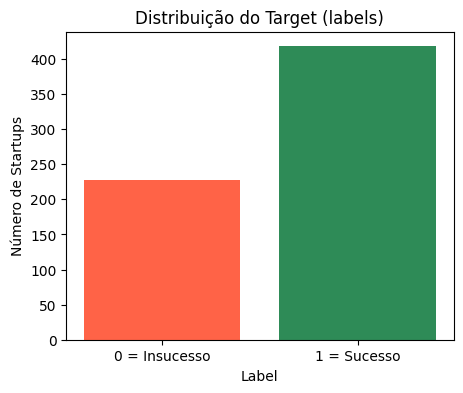

0 (insucesso): 228 startups (~35.3%)
1 (sucesso): 418 startups (~64.7%)


In [ ]:
# Contagem de cada classe
class_counts = df['labels'].value_counts().sort_index()

# Plot do gráfico
plt.figure(figsize=(5,4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['tomato','seagreen'])
plt.title("Distribuição do Target (labels)")
plt.xlabel("Label")
plt.ylabel("Número de Startups")
plt.xticks([0,1], ["0 = Insucesso", "1 = Sucesso"])
plt.show()

total = len(df)
print(f"0 (insucesso): {class_counts[0]} startups (~{class_counts[0]/total:.1%})")
print(f"1 (sucesso): {class_counts[1]} startups (~{class_counts[1]/total:.1%})")

**5.2 Análise entre target e tempo até a primeira captação**

- Variável analisada: `age_first_funding_year`
- Boa forma de avaliar se existe alguma correlação entre captar investimento cedo e as chances de sucesso.
- Conclusão: Os gráficos de age_first_funding_year mostram que a maioria das startups consegue captar o primeiro investimento nos primeiros cinco anos de vida, com poucos casos tardios que se configuram como outliers; além disso, ao comparar sucesso e insucesso, percebe-se que startups bem-sucedidas tendem a captar mais cedo, com valores mais concentrados em idades menores, enquanto as de insucesso apresentam distribuição mais espalhada, sugerindo que o tempo até o primeiro funding é um fator relevante e que captar cedo está associado a maiores chances de sucesso.

Text(0, 0.5, 'Anos até o primeiro funding')

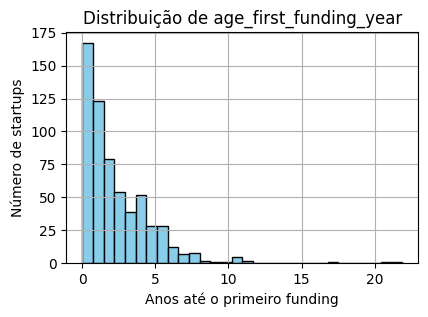

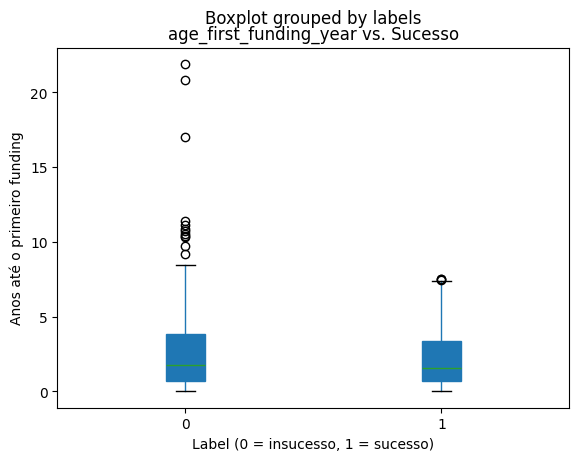

In [ ]:
col = "age_first_funding_year"

plt.figure(figsize=(10,3))

# Histograma geral
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o primeiro funding")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o primeiro funding")

**5.3 Análise entre target e tempo até a última captação**


**Agrupamento do dataset com base nas rodadas de investimento e número de funcionários**

- Variável em análise: `age_last_funding_year`
- Conclusão: A análise da variável mostra que a maior parte das startups realizou sua última rodada de investimento também nos primeiros anos de vida, mas a cauda da distribuição é longa, indicando que algumas empresas captam por muitos anos. No boxplot, percebe-se que startups de sucesso tendem a concentrar seus últimos fundings em períodos mais iniciais e medianos, enquanto as de insucesso apresentam maior dispersão e alguns casos extremos. Isso sugere que, embora seja possível captar em fases avançadas, a tendência é que startups bem-sucedidas tenham conseguido consolidar rodadas significativas de investimento relativamente cedo, o que reforça a ideia de que manter um histórico de funding consistente e precoce está associado a maiores chances de sucesso.

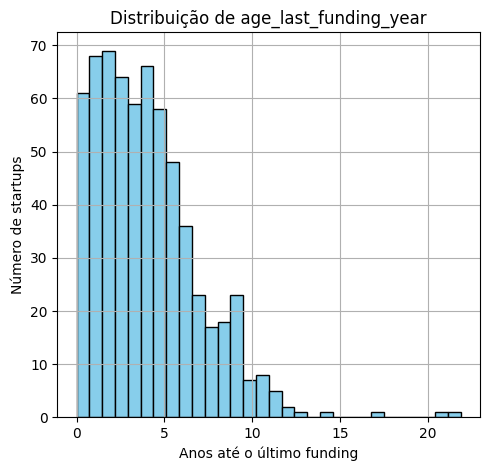

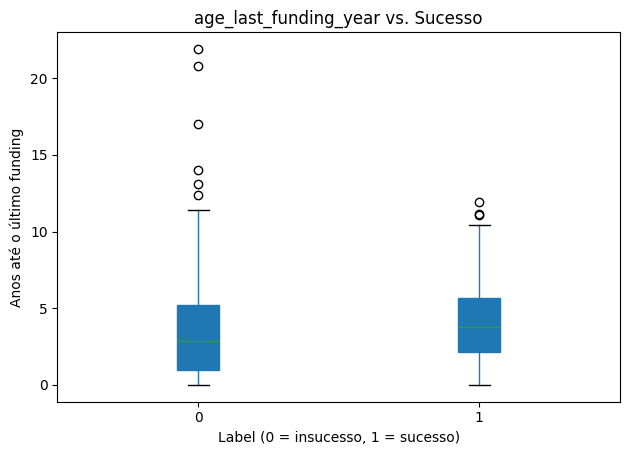

In [ ]:
col = "age_last_funding_year"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o último funding")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o último funding")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()


### Análise entre target e tempo até o primeiro milestone

- métrica avaliada: `age_first_milestone_year`
- conclusão: A análise mostra que a maior parte das startups atinge seu primeiro marco relevante ainda nos primeiros anos de operação, embora exista uma cauda longa indicando que algumas só conquistam milestones mais tarde. No boxplot, observa-se que startups de sucesso tendem a alcançar esses milestones de forma mais precoce e com distribuição mais concentrada, enquanto as de insucesso apresentam maior dispersão e valores mais elevados, sugerindo que demorar muito para atingir o primeiro marco pode estar associado a menores chances de sucesso. Assim, essa variável parece relevante para o modelo, pois reforça a ideia de que atingir milestones cedo é um sinal positivo para o futuro da startup. 

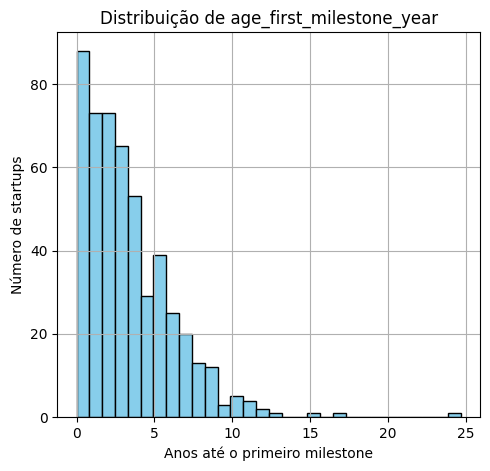

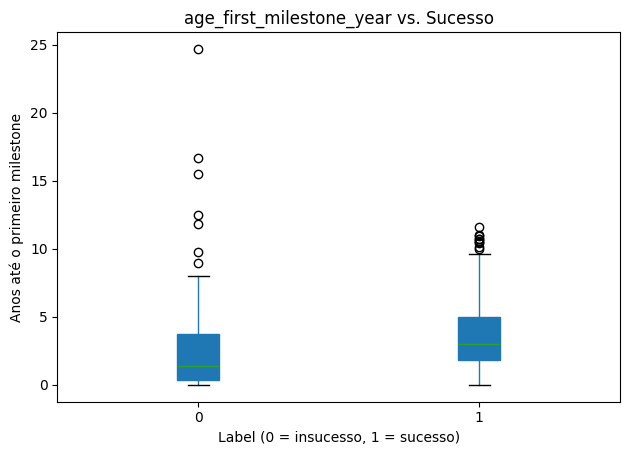

In [ ]:
col = "age_first_milestone_year"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o primeiro milestone")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o primeiro milestone")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

### Análise entre target e tempo até o último milestone

- métrica avaliada: `age_last_milestone_year`
- conclusão: A análise mostra que a maioria das startups registra seu último milestone dentro dos primeiros anos de operação, mas há casos em que esses eventos ocorrem em fases bem mais avançadas, criando uma cauda longa na distribuição. No boxplot, percebe-se que startups de sucesso apresentam valores mais concentrados em períodos menores, indicando que acumulam milestones de forma mais precoce e consistente, enquanto startups de insucesso exibem maior dispersão e valores mais elevados, sugerindo que alcançar milestones tardiamente pode estar associado a menor probabilidade de sucesso. Assim, essa variável reforça a importância de atingir marcos relevantes de forma contínua e relativamente cedo como sinal de trajetória positiva. 

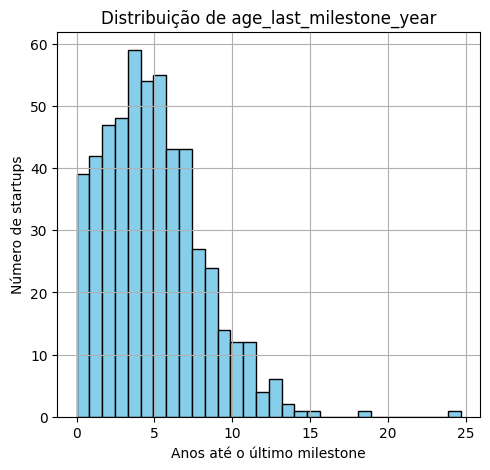

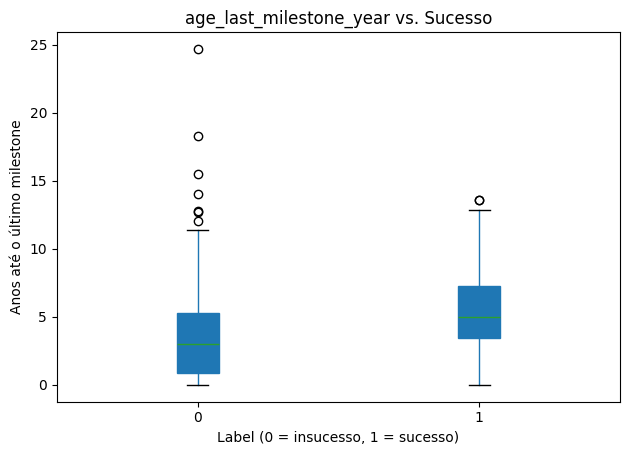

In [ ]:
col = "age_last_milestone_year"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o último milestone")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o último milestone")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

### Análise entre target e quantidade de conexões (relationship)

- A análise mostra que a maioria das startups possui um número relativamente baixo de conexões (fundadores, executivos e investidores), mas existem alguns casos extremos com dezenas de relacionamentos, configurando outliers na distribuição. No boxplot, observa-se que startups de sucesso apresentam uma mediana maior de relacionamentos do que as de insucesso, sugerindo que ter uma rede mais ampla está associado a melhores resultados. Ainda assim, há sobreposição entre os grupos, indicando que apenas o número de conexões, isoladamente, não garante sucesso, mas pode ser um fator relevante dentro de um conjunto de variáveis.

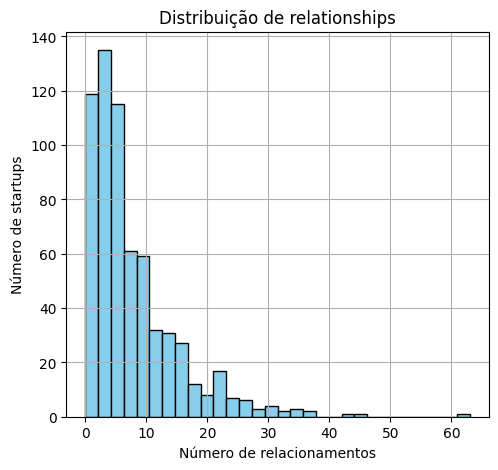

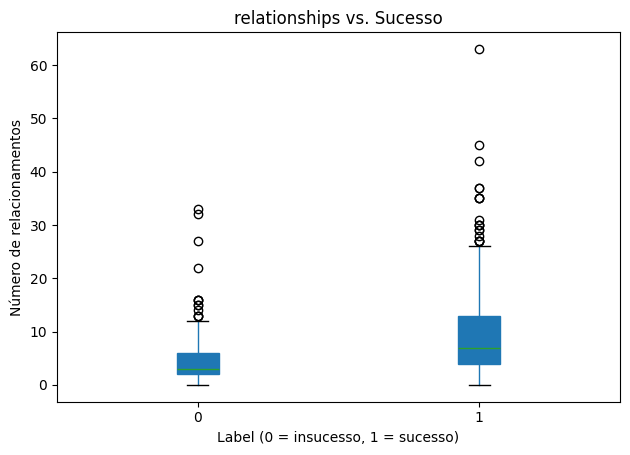

In [ ]:
col = "relationships"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de relacionamentos")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Número de relacionamentos")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

### Análise entre target e quantidade de rodadas de investimento

- A análise mostra que a maioria das startups passa por poucas rodadas de captação, concentrando-se entre uma e três rodadas, enquanto apenas algumas alcançam um número elevado, funcionando como outliers. No boxplot, fica evidente que startups de sucesso tendem a ter uma mediana mais alta de rodadas do que as de insucesso, o que sugere que conseguir atrair múltiplas rodadas de investimento está associado a uma trajetória mais sustentável e promissora. Apesar disso, há sobreposição entre os grupos, indicando que apenas o número de rodadas, isoladamente, não determina o sucesso, mas é um forte indicativo quando analisado em conjunto com outras variáveis.

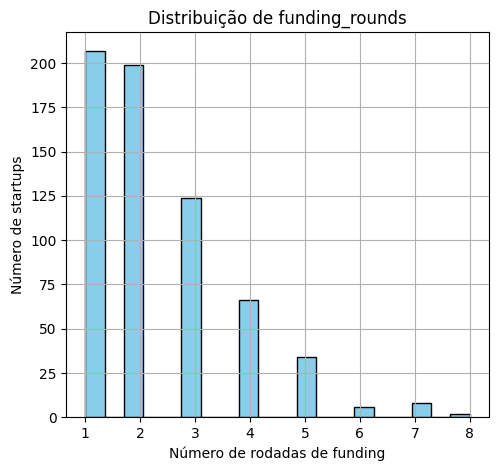

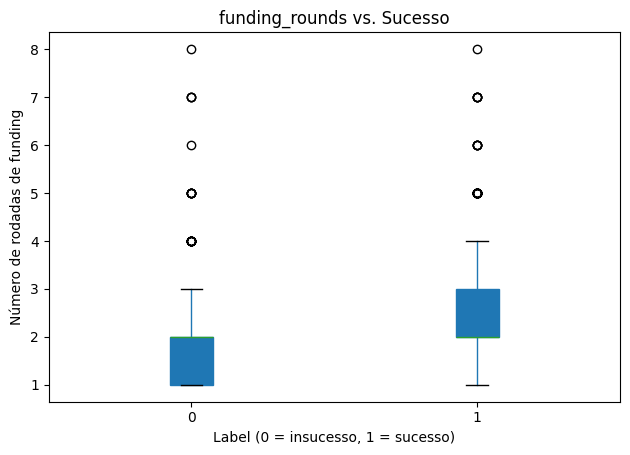

In [ ]:
col = "funding_rounds"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de rodadas de funding")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Número de rodadas de funding")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

### Análise entre target e valor total captado


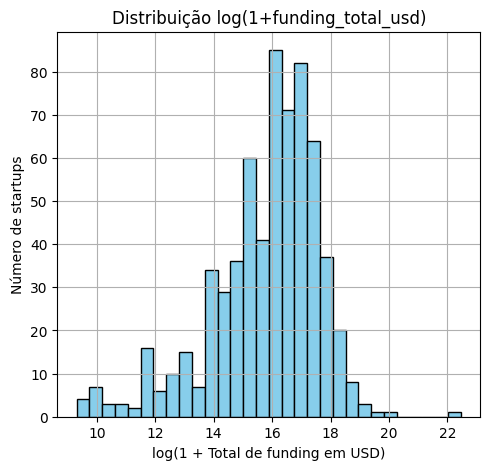

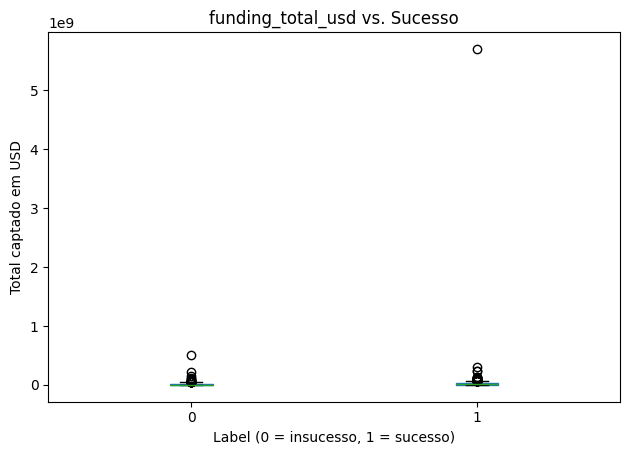

In [ ]:

col = "funding_total_usd"

plt.figure(figsize=(12,5))

# Histograma geral (log-transformado para visualização)
plt.subplot(1,2,1)
df[col].apply(lambda x: np.log1p(x)).hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição log(1+{col})")
plt.xlabel("log(1 + Total de funding em USD)")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (sem log, para manter escala original)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Total captado em USD")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

### Análise entre target e contagem de marcos relevantes

- A análise da variável milestones mostra que a maioria das startups possui apenas alguns marcos registrados (em torno de 1 a 3), enquanto poucas acumulam um número muito maior, configurando outliers. O boxplot indica que startups de sucesso apresentam uma mediana mais elevada de milestones do que as de insucesso, sugerindo que conquistar e registrar diversos marcos relevantes está associado a maiores chances de prosperar. No entanto, também há sobreposição entre os grupos, o que indica que apenas o número bruto de milestones não garante o sucesso, mas funciona como um bom indicador complementar dentro do conjunto de variáveis.

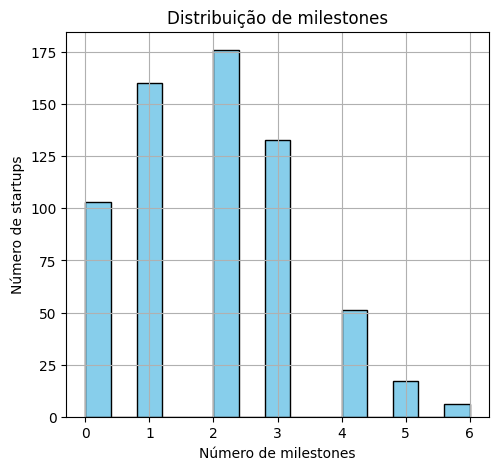

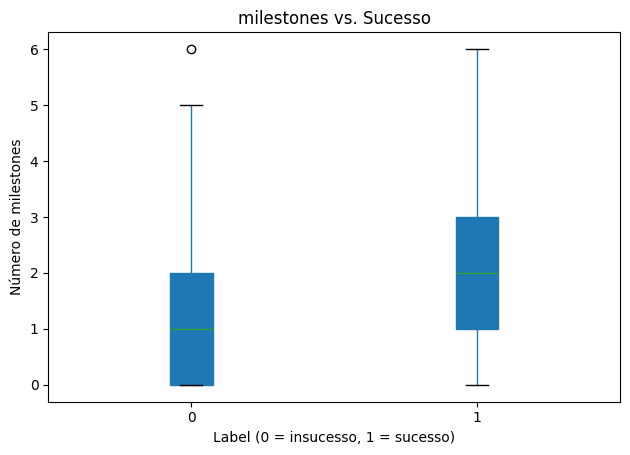

In [ ]:
col = "milestones"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=15, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de milestones")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Número de milestones")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

# Análise entre target e média de investidores por rodada

A análise da variável avg_participants mostra que a maioria das startups atrai poucos investidores por rodada, com a distribuição concentrada em valores baixos, mas existem casos em que a média é significativamente maior, formando outliers. No boxplot, nota-se que startups de sucesso tendem a ter uma mediana mais elevada de participantes do que as de insucesso, sugerindo que a capacidade de atrair um grupo mais amplo de investidores em cada rodada está associada a melhores resultados. Ainda assim, a sobreposição entre os grupos indica que esse fator, isoladamente, não define o sucesso, mas serve como um sinal de validação do mercado que complementa outras variáveis já analisadas.

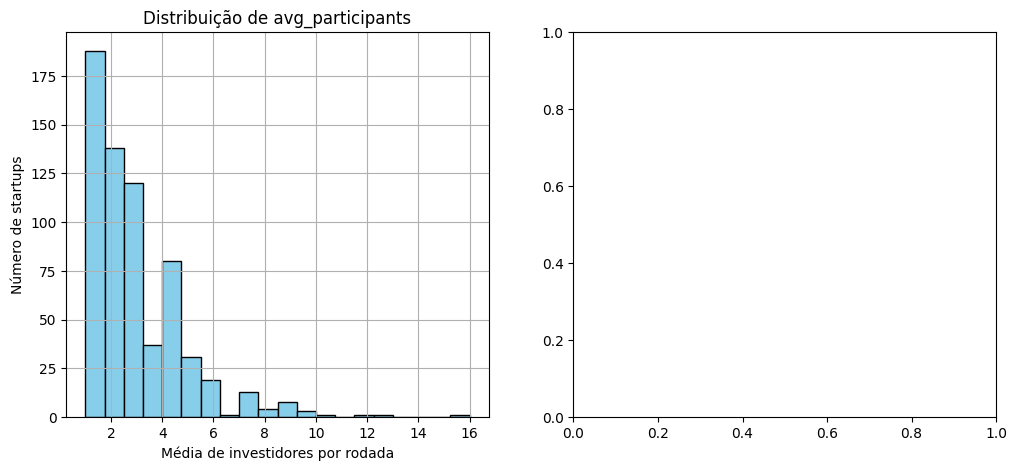

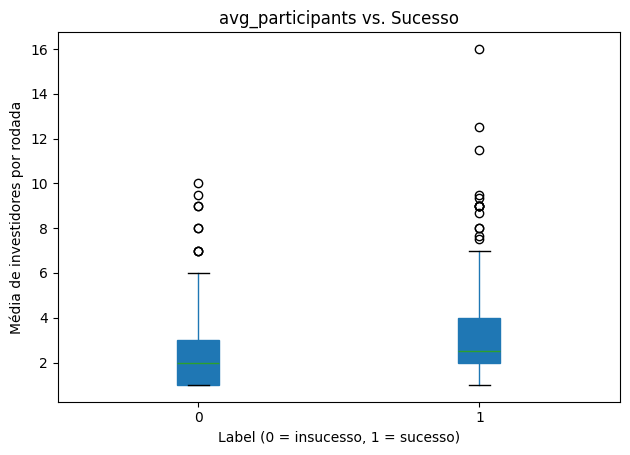

In [ ]:

col = "avg_participants"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Média de investidores por rodada")
plt.ylabel("Número de startups")

# Boxplot comparando sucesso x insucesso (coluna 2)
plt.subplot(1,2,2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Média de investidores por rodada")

# Remove título automático extra
plt.suptitle("")

plt.tight_layout()
plt.show()

Conclusões:

Startups de sucesso compartilham alguns padrões:

- Captam mais cedo e em maior quantidade, tanto em número de rodadas quanto em valor total.

- Atingem milestones mais rápido e acumulam mais marcos relevantes.

- Têm uma rede maior de relacionamentos e conseguem atrair mais investidores por rodada.

Ou seja, há uma consistência temporal e quantitativa: quanto mais cedo e mais frequentes forem os sinais de tração (fundings, milestones, investidores), maior a chance de a startup ser bem-sucedida.

**Análise target e localidade**

- A interpretação da análise por localização mostra que a taxa de sucesso varia de forma significativa entre os estados. Startups sediadas na Califórnia (is_CA) tendem a apresentar a maior proporção de sucesso, refletindo a força do ecossistema de inovação local e a maior disponibilidade de capital e networking no Vale do Silício. Em seguida, aparecem Nova Iorque (is_NY) e Massachusetts (is_MA), que também possuem polos de tecnologia e acesso a investidores relevantes. Já Texas (is_TX) e a categoria outros estados (is_otherstate) apresentam taxas mais baixas, sugerindo que, embora seja possível ter sucesso fora dos principais hubs, a localização em ecossistemas consolidados parece estar associada a maiores chances de êxito. Assim, a variável de localização reforça a ideia de que o ambiente em que a startup nasce pode influenciar de forma importante suas perspectivas de crescimento e sobrevivência.

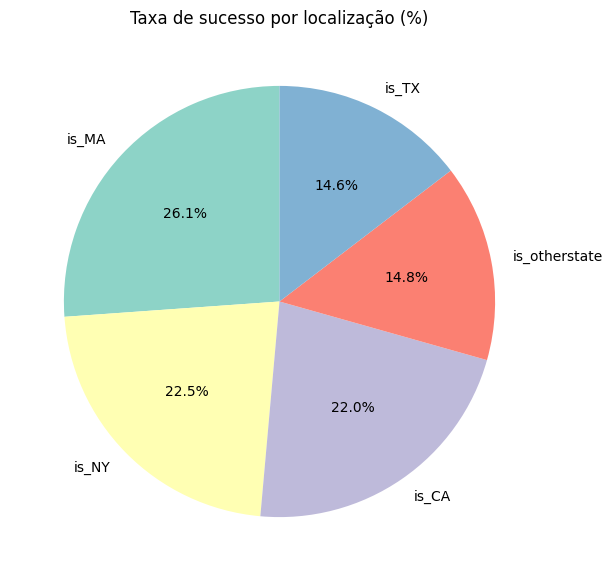

In [ ]:
# Lista das variáveis de localização
loc_cols = ["is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate"]

# Calcular a taxa de sucesso (labels=1) em cada estado
success_rates = {}
for col in loc_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame para facilitar o plot
loc_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=False)

# Gráfico de pizza
plt.figure(figsize=(7,7))
plt.pie(
    loc_success["taxa_sucesso"], 
    labels=loc_success.index, 
    autopct="%.1f%%", 
    startangle=90,
    colors=plt.cm.Set3.colors
)
plt.title("Taxa de sucesso por localização (%)")
plt.show()



**Análise target e setor**

A análise das variáveis de setor/mercado mostra que, apesar de pequenas variações entre categorias, a maioria dos setores apresenta taxas de sucesso relativamente próximas, geralmente entre 60% e 80%. Isso indica que, neste dataset, o setor em si não é um fator decisivo para o sucesso de uma startup, diferentemente de variáveis como funding ou milestones, que mostraram diferenças bem mais expressivas. Assim, embora o setor possa adicionar algum sinal ao modelo, ele tende a ter baixo peso explicativo e provavelmente não será um grande diferencial na previsão, servindo mais como uma informação complementar do que determinante.

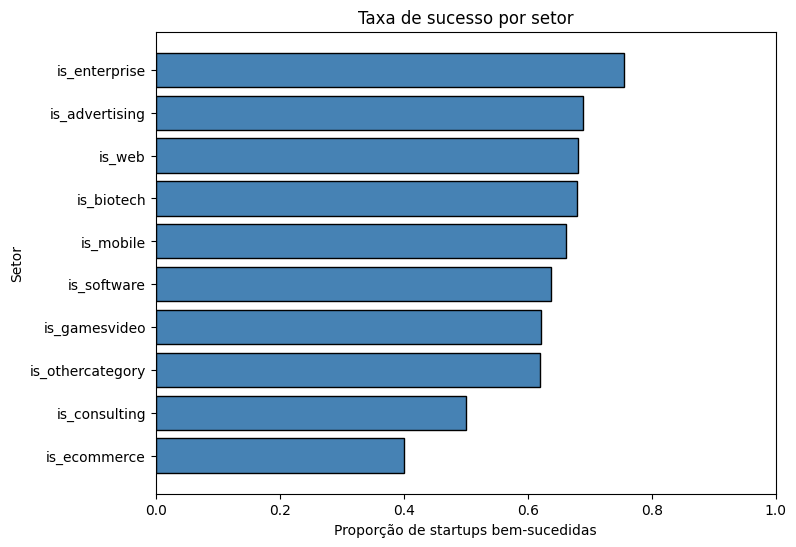

labels              1.000000
is_enterprise       0.067350
is_web              0.029337
is_advertising      0.023952
is_biotech          0.013831
is_mobile           0.010135
is_software        -0.008263
is_gamesvideo      -0.013120
is_consulting      -0.017149
is_othercategory   -0.038491
is_ecommerce       -0.092407
Name: labels, dtype: float64

In [ ]:

# Lista das variáveis de setor/mercado
sector_cols = [
    "is_software", "is_web", "is_mobile", "is_enterprise", "is_advertising",
    "is_gamesvideo", "is_ecommerce", "is_biotech", "is_consulting", "is_othercategory"
]

# Calcular a taxa de sucesso (labels=1) em cada setor
success_rates = {}
for col in sector_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame
sector_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(8,6))
plt.barh(sector_success.index, sector_success["taxa_sucesso"], color="steelblue", edgecolor="black")
plt.title("Taxa de sucesso por setor")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Setor")
plt.xlim(0,1)
plt.show()

df[[
    "is_software", "is_web", "is_mobile", "is_enterprise", "is_advertising",
    "is_gamesvideo", "is_ecommerce", "is_biotech", "is_consulting", "is_othercategory",
    "labels"
]].corr()["labels"].sort_values(ascending=False)


**Análise target e tipo de financiamento**

Startups que receberam venture capital ou avançaram para rodadas como Série B, C ou D apresentam taxas de sucesso mais altas, indicando tração e confiança do mercado. Já aquelas que pararam em fases iniciais, como apenas investimento anjo ou até a Série A, têm taxas menores. Em resumo, quanto mais avançada a captação, maior a chance de sucesso.

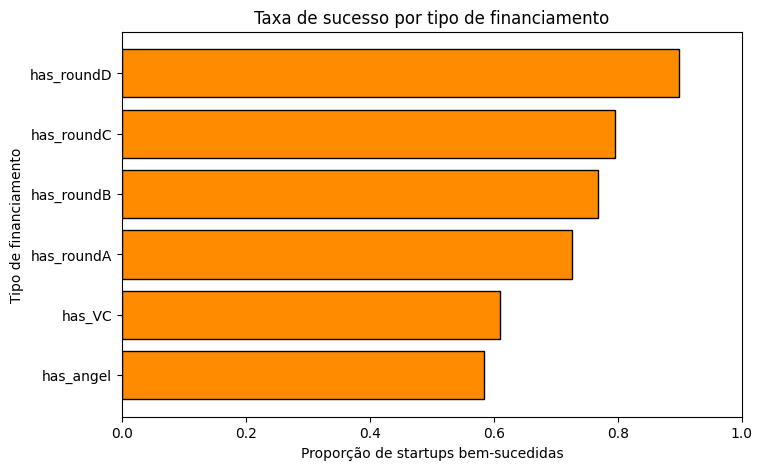

In [ ]:

# Lista das variáveis de financiamento
funding_cols = ["has_VC", "has_angel", "has_roundA", "has_roundB", "has_roundC", "has_roundD"]

# Calcular a taxa de sucesso (labels=1) em cada tipo de funding
success_rates = {}
for col in funding_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame
funding_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(8,5))
plt.barh(funding_success.index, funding_success["taxa_sucesso"], color="darkorange", edgecolor="black")
plt.title("Taxa de sucesso por tipo de financiamento")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Tipo de financiamento")
plt.xlim(0,1)
plt.show()

**Análise entre target e categoria**

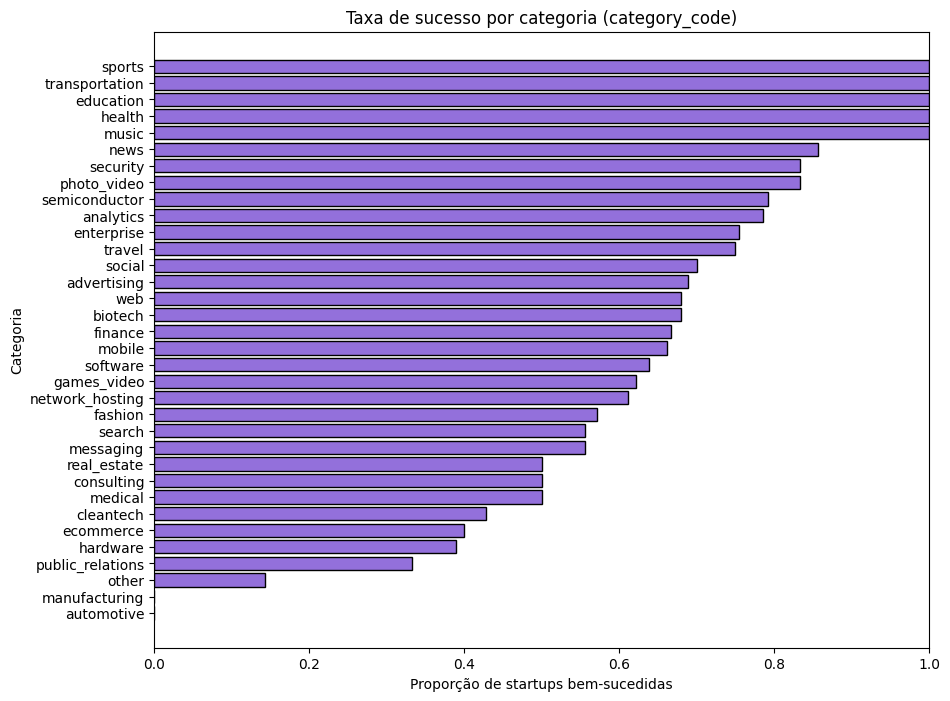

In [ ]:

col = "category_code"

# Calcular a taxa de sucesso média por categoria
category_success = df.groupby(col)["labels"].mean().sort_values(ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(10,8))
plt.barh(category_success.index, category_success.values, color="mediumpurple", edgecolor="black")
plt.title("Taxa de sucesso por categoria (category_code)")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Categoria")
plt.xlim(0,1)
plt.show()


- confirmar se os 100% de sucesso nos setores sports, transportation, education, health e music são de fato robustos ou apenas ruído por terem poucas startups

In [ ]:
# Setores de interesse
setores = ["sports", "transportation", "education", "health", "music"]

# Contagem de startups nesses setores
category_counts = df[df["category_code"].isin(setores)]["category_code"].value_counts()

print(category_counts)


category_code
music             5
health            2
education         2
transportation    2
sports            1
Name: count, dtype: int64


A análise dos setores sports, transportation, education, health e music mostra que, no dataset, todas as startups desses segmentos tiveram 100% de sucesso. Esse resultado sugere um forte sinal positivo, mas como há baixa quantidade de representantes nessas áreas, existe risco de overfitting, já que o modelo pode aprender uma regra que não se generaliza fora da amostra.

### 6. Formulação de Hipóteses (até 1,0 pt)

Formulação de três hipóteses que possam explicar os fatores que influenciam o sucesso da empresas.

### 7. Seleção de Features (até 1,0 pt)

Escolha das features mais relevantes para o modelo com base em sua análise exploratória e hipóteses formuladas.

### 8. Construção e Avaliação do Modelo (até 2,0 pts)

Seleção de um modelo de machine learning adequado (ou uma combinação de modelos) que maximize a capacidade preditiva. A avaliação deve incluir métricas como acurácia, precisão, recall, e F1-score.

### 9. Finetuning de Hiperparâmetros (até 1,0 pt)

Realização de um ajuste fino (finetuning) dos hiperparâmetros do modelo para otimizar o desempenho. Aqui estão detalhes do processo de busca e as justificativas para as escolhas feitas.